In [1]:
from pyspark.sql import SparkSession
# Initialize a SparkSession
spark = SparkSession.builder \
    .appName("mandaue_exploratory_data_analysis") \
    .getOrCreate()

In [2]:
# City merged Dataframe
city_merged_10_years_file_path = "city_merged_10 years.csv"
city_merged_10_years_df = spark.read.csv(city_merged_10_years_file_path, header=True, inferSchema=True)
# Display the schema of the DataFrame
city_merged_10_years_df.printSchema()
city_merged_10_years_df.describe("case_total_dengue", "death_total_dengue", "pop_count_mean", "hospital_count", "doctors_count").show()

root
 |-- adm3_en: string (nullable = true)
 |-- adm3_pcode: string (nullable = true)
 |-- date: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- brgy_is_coastal: double (nullable = true)
 |-- co: double (nullable = true)
 |-- doctors_count: double (nullable = true)
 |-- hospital_count: double (nullable = true)
 |-- osm_canal_nearest: double (nullable = true)
 |-- osm_drain_nearest: double (nullable = true)
 |-- osm_water_nearest: double (nullable = true)
 |-- pct_area_flood_hazard_100yr_high: double (nullable = true)
 |-- pct_area_flood_hazard_100yr_low: double (nullable = true)
 |-- pct_area_flood_hazard_100yr_med: double (nullable = true)
 |-- pop_count_mean: double (nullable = true)
 |-- pop_count_total: double (nullable = true)
 |-- pop_density_mean: double (nullable = true)
 |-- pr: double (nullable = true)
 |-- case_total_dengue: integer (nullable = true)
 |-- death_total_dengue: integer (nullable = true)

+-------+---------

In [4]:
from pyspark.sql import functions as F

# Barangay merged Dataframe
barangay_merged_10_years_file_path = "barangay_merged_10 years.csv"
barangay_merged_10_years_df = spark.read.csv(barangay_merged_10_years_file_path, header=True, inferSchema=True)
# Display the schema of the DataFrame
barangay_merged_10_years_df.printSchema()

# Dictionary to map original column names to shorter names
column_mapping = {
    "brgy_total_area": "total_area",
    "pct_area_flood_hazard_100yr_high": "flood_hazard_high",
    "pct_area_flood_hazard_100yr_med": "flood_hazard_med",
    "pct_area_flood_hazard_100yr_low": "flood_hazard_low",
}

# Apply the renaming and select only the desired columns
brgy_health_hazard_df = barangay_merged_10_years_df.select(
    [F.col(old).alias(new) for old, new in column_mapping.items()]
)

# Display summary statistics for the selected and renamed columns
brgy_health_hazard_df.describe().show()

root
 |-- date: string (nullable = true)
 |-- adm4_pcode: string (nullable = true)
 |-- adm3_en: string (nullable = true)
 |-- adm4_en: string (nullable = true)
 |-- brgy_total_area: double (nullable = true)
 |-- brgy_distance_to_coast: double (nullable = true)
 |-- brgy_is_coastal: boolean (nullable = true)
 |-- heat_index: double (nullable = true)
 |-- pr: double (nullable = true)
 |-- osm_canal_nearest: double (nullable = true)
 |-- osm_drain_nearest: double (nullable = true)
 |-- osm_water_nearest: double (nullable = true)
 |-- pct_area_flood_hazard_100yr_high: double (nullable = true)
 |-- pct_area_flood_hazard_100yr_low: double (nullable = true)
 |-- pct_area_flood_hazard_100yr_med: double (nullable = true)
 |-- pop_count_mean: double (nullable = true)
 |-- pop_count_total: double (nullable = true)
 |-- pop_density_mean: double (nullable = true)

+-------+-----------------+-----------------+------------------+------------------+
|summary|       total_area|flood_hazard_high|  floo

In [6]:
# Select the desired columns into a new DataFrame
brgy_climate_df = barangay_merged_10_years_df.select(
    F.col("pr"),
)

# Show summary statistics for the selected columns
brgy_climate_df.describe().show()


+-------+------------------+
|summary|                pr|
+-------+------------------+
|  count|             98631|
|   mean|4.7412392655453175|
| stddev| 8.145286474348818|
|    min|               0.0|
|    max|             93.63|
+-------+------------------+



In [7]:
from pyspark.sql.functions import col, sum, desc, asc
# Assuming barangay_merged_10_years_df is your dataframe
# Find the most flooded barangay for each hazard level
most_flooded_high = barangay_merged_10_years_df.orderBy(desc("pct_area_flood_hazard_100yr_high")).select("adm4_en", "pct_area_flood_hazard_100yr_high").first()
most_flooded_med = barangay_merged_10_years_df.orderBy(desc("pct_area_flood_hazard_100yr_med")).select("adm4_en", "pct_area_flood_hazard_100yr_med").first()
most_flooded_low = barangay_merged_10_years_df.orderBy(desc("pct_area_flood_hazard_100yr_low")).select("adm4_en", "pct_area_flood_hazard_100yr_low").first()

# Calculate the average flood hazard percentage for each barangay
average_flood_hazard_df = barangay_merged_10_years_df.withColumn(
    "average_flood_hazard_pct",
    (col("pct_area_flood_hazard_100yr_high") + col("pct_area_flood_hazard_100yr_med") + col("pct_area_flood_hazard_100yr_low")) / 3
)

# Get the barangay with the highest average flood hazard percentage
most_flooded_overall = average_flood_hazard_df.orderBy(desc("average_flood_hazard_pct")).select("adm4_en", "average_flood_hazard_pct").first()

# Show the results
print(f"Most flooded barangay (High hazard): {most_flooded_high['adm4_en']} with {most_flooded_high['pct_area_flood_hazard_100yr_high']}%")
print(f"Most flooded barangay (Medium hazard): {most_flooded_med['adm4_en']} with {most_flooded_med['pct_area_flood_hazard_100yr_med']}%")
print(f"Most flooded barangay (Low hazard): {most_flooded_low['adm4_en']} with {most_flooded_low['pct_area_flood_hazard_100yr_low']}%")
print(f"Most flooded barangay overall: {most_flooded_overall['adm4_en']} with {most_flooded_overall['average_flood_hazard_pct']}% average flood hazard area")

Most flooded barangay (High hazard): Tingub with 38.5303%
Most flooded barangay (Medium hazard): Subangdaku with 45.5713%
Most flooded barangay (Low hazard): Opao with 31.1449%
Most flooded barangay overall: Tingub with 24.063% average flood hazard area


In [8]:
# Assuming barangay_merged_10_years_df is your dataframe and contains only Mandaue City data

# Calculate total area
total_area = barangay_merged_10_years_df.agg(sum("brgy_total_area")).collect()[0][0]

# Calculate weighted flood hazard for high, medium, and low flood hazards
weighted_flood_hazard_high = barangay_merged_10_years_df.withColumn(
    "weighted_flood_hazard_high",
    (col("brgy_total_area") * col("pct_area_flood_hazard_100yr_high")) / 100
).agg(sum("weighted_flood_hazard_high")).collect()[0][0]

weighted_flood_hazard_med = barangay_merged_10_years_df.withColumn(
    "weighted_flood_hazard_med",
    (col("brgy_total_area") * col("pct_area_flood_hazard_100yr_med")) / 100
).agg(sum("weighted_flood_hazard_med")).collect()[0][0]

weighted_flood_hazard_low = barangay_merged_10_years_df.withColumn(
    "weighted_flood_hazard_low",
    (col("brgy_total_area") * col("pct_area_flood_hazard_100yr_low")) / 100
).agg(sum("weighted_flood_hazard_low")).collect()[0][0]

# Calculate the overall percentage of each flood hazard type
overall_flood_hazard_percentage_high = (weighted_flood_hazard_high / total_area) * 100
overall_flood_hazard_percentage_med = (weighted_flood_hazard_med / total_area) * 100
overall_flood_hazard_percentage_low = (weighted_flood_hazard_low / total_area) * 100

# Print the results
print(f"Overall percentage of high flood hazard for Mandaue City: {overall_flood_hazard_percentage_high:.2f}%")
print(f"Overall percentage of medium flood hazard for Mandaue City: {overall_flood_hazard_percentage_med:.2f}%")
print(f"Overall percentage of low flood hazard for Mandaue City: {overall_flood_hazard_percentage_low:.2f}%")

Overall percentage of high flood hazard for Mandaue City: 5.68%
Overall percentage of medium flood hazard for Mandaue City: 17.67%
Overall percentage of low flood hazard for Mandaue City: 16.44%


In [9]:
# Create a new DataFrame with additional calculated columns

from pyspark.sql.functions import avg

city_merged_analysis_df = city_merged_10_years_df.withColumn(
    "case_rate_per_100k",
    (col("case_total_dengue") / col("pop_count_total")) * 100000
).withColumn(
    "death_rate_per_100k",
    (col("death_total_dengue") / col("pop_count_total")) * 100000
).withColumn(
    "fatality_rate",
    (col("death_total_dengue") / col("case_total_dengue")) * 100
).withColumn(
    "doctors_per_100k",
    (col("doctors_count") / col("pop_count_total")) * 100000
).withColumn(
    "hospitals_per_100k",
    (col("hospital_count") / col("pop_count_total")) * 100000
)

# Remove rows with null values in the relevant columns
city_merged_analysis_df_clean = city_merged_analysis_df.dropna(subset=[
    "case_rate_per_100k",
    "death_rate_per_100k",
    "fatality_rate",
    "doctors_per_100k",
    "hospitals_per_100k"
])

# Compute average values for the entire city
average_values = city_merged_analysis_df_clean.agg(
    avg("case_rate_per_100k").alias("avg_case_rate_per_100k"),
    avg("death_rate_per_100k").alias("avg_death_rate_per_100k"),
    avg("fatality_rate").alias("avg_fatality_rate"),
    avg("doctors_per_100k").alias("avg_doctors_per_100k"),
    avg("hospitals_per_100k").alias("avg_hospitals_per_100k")
).collect()[0]

# Print the aggregated averages
print(f"Average case rate per 100k: {average_values['avg_case_rate_per_100k']:.2f}")
print(f"Average death rate per 100k: {average_values['avg_death_rate_per_100k']:.2f}")
print(f"Average fatality rate: {average_values['avg_fatality_rate']:.2f}")
print(f"Average doctors per 100k: {average_values['avg_doctors_per_100k']:.2f}")
print(f"Average hospitals per 100k: {average_values['avg_hospitals_per_100k']:.2f}")

Average case rate per 100k: 5.54
Average death rate per 100k: 0.04
Average fatality rate: 1.51
Average doctors per 100k: 0.88
Average hospitals per 100k: 2.03


In [10]:
from pyspark.sql.functions import col, expr, min as spark_min, max as spark_max
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import avg, sum as spark_sum

# Step 1: Select relevant columns and compute average flood hazard
clustering_df = barangay_merged_10_years_df.select(
    'adm4_en',
    'pop_count_total',
    'pct_area_flood_hazard_100yr_high',
    'pct_area_flood_hazard_100yr_med',
    'pct_area_flood_hazard_100yr_low'
).withColumn(
    'avg_pct_area_flood_hazard',
    expr("(pct_area_flood_hazard_100yr_high + pct_area_flood_hazard_100yr_med + pct_area_flood_hazard_100yr_low) / 3")
)

# Step 2: Remove rows with null values
clustering_df = clustering_df.dropna(subset=['pop_count_total', 'avg_pct_area_flood_hazard'])



# Show the result to verify
clustering_df.show()

# Step 1: Select relevant columns and compute average flood hazard
clustering_df = barangay_merged_10_years_df.select(
    'adm4_en',
    'pop_count_total',
    'pct_area_flood_hazard_100yr_high',
    'pct_area_flood_hazard_100yr_med',
    'pct_area_flood_hazard_100yr_low'
).withColumn(
    'avg_pct_area_flood_hazard',
    expr("(pct_area_flood_hazard_100yr_high + pct_area_flood_hazard_100yr_med + pct_area_flood_hazard_100yr_low) / 3")
)

# Step 3: Aggregate table based on 'adm4_en'
clustering_df = clustering_df.groupBy('adm4_en').agg(
    avg('pop_count_total').alias('pop_count_total'),
    avg('avg_pct_area_flood_hazard').alias('avg_pct_area_flood_hazard')
)

# Step 2: Remove rows with null values
clustering_df = clustering_df.dropna(subset=['pop_count_total', 'avg_pct_area_flood_hazard'])

# Step 3: Normalize the columns using Min-Max scaling
min_pop = clustering_df.agg(spark_min('pop_count_total')).collect()[0][0]
max_pop = clustering_df.agg(spark_max('pop_count_total')).collect()[0][0]

clustering_df = clustering_df.withColumn(
    'pop_count_total_Normalized',
    (col('pop_count_total') - min_pop) / (max_pop - min_pop)
)

min_flood = clustering_df.agg(spark_min('avg_pct_area_flood_hazard')).collect()[0][0]
max_flood = clustering_df.agg(spark_max('avg_pct_area_flood_hazard')).collect()[0][0]

clustering_df = clustering_df.withColumn(
    'avg_pct_area_flood_hazard_Normalized',
    (col('avg_pct_area_flood_hazard') - min_flood) / (max_flood - min_flood)
)

# Step 4: Assemble features for clustering
assembler = VectorAssembler(
    inputCols=['pop_count_total_Normalized', 'avg_pct_area_flood_hazard_Normalized'],
    outputCol='features'
)
dataset = assembler.transform(clustering_df)

# Step 5: Remove rows with null values in the feature columns
dataset = dataset.dropna(subset=['pop_count_total_Normalized', 'avg_pct_area_flood_hazard_Normalized'])

# Display descriptive statistics to check the prepared dataset
dataset.describe().show()


+---------------+---------------+--------------------------------+-------------------------------+-------------------------------+-------------------------+
|        adm4_en|pop_count_total|pct_area_flood_hazard_100yr_high|pct_area_flood_hazard_100yr_med|pct_area_flood_hazard_100yr_low|avg_pct_area_flood_hazard|
+---------------+---------------+--------------------------------+-------------------------------+-------------------------------+-------------------------+
|    Alang-alang|    14482.48828|                          3.8883|                        27.9909|                        17.3911|       16.423433333333335|
|         Umapad|    23250.31641|                          3.8599|                        21.6809|                        12.5203|       12.687033333333334|
|         Tipolo|    29959.33594|                          0.0044|                         14.772|                        28.0023|       14.259566666666666|
|         Tingub|    8646.967773|                         

+---------------+--------------------------+------------------------------------+----------+
|        adm4_en|pop_count_total_Normalized|avg_pct_area_flood_hazard_Normalized|prediction|
+---------------+--------------------------+------------------------------------+----------+
|        Banilad|        0.4706362212619998|                  0.4454586529772559|         0|
|        Tawason|       0.08133395301935935|                 0.14691924144251925|         0|
|           Opao|        0.3217892081474281|                  0.8193827587753882|         1|
|         Tipolo|                       1.0|                  0.5287807707343929|         2|
|           Looc|        0.5934948066617048|                 0.14069940333134595|         0|
|          Basak|        0.1337848864767461|                  0.7244188729307275|         1|
|       Maguikay|       0.46983710716595434|                  0.5383909173059512|         1|
|Ibabao-Estancia|        0.2201924873844392|                  0.364216

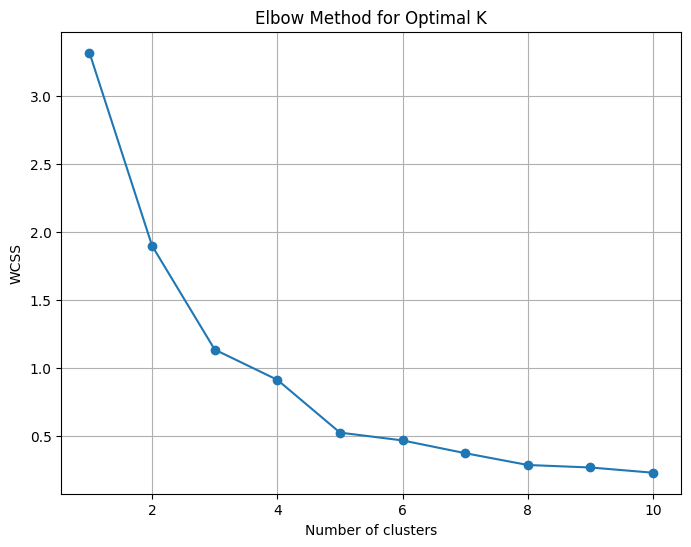

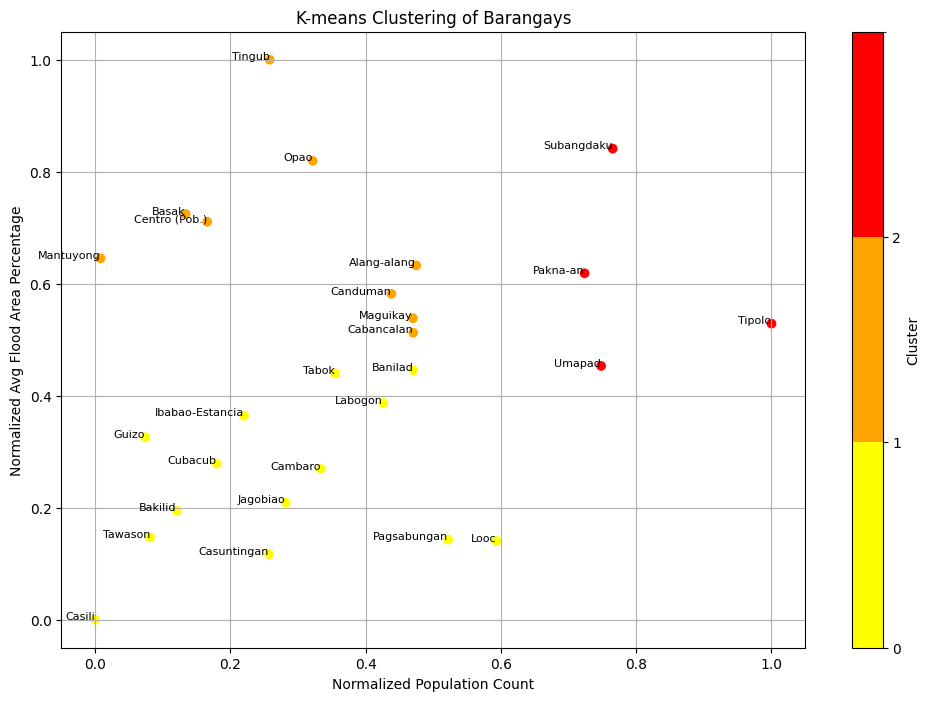

In [61]:
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from sklearn.cluster import KMeans as skKMeans
import matplotlib.colors as mcolors

# Initialize KMeans with correct parameters
kmeans = KMeans(k=3, seed=42)

# Fit the model
model = kmeans.fit(dataset)

# Transform the data
predictions = model.transform(dataset)

# Add cluster predictions and adm4_en to the DataFrame
result_df = predictions.select('adm4_en', 'pop_count_total_Normalized', 'avg_pct_area_flood_hazard_Normalized', 'prediction')

# Show the results
result_df.show()

# Convert to Pandas DataFrame for visualization
pandas_df = result_df.toPandas()

# Elbow method to determine the optimal number of clusters
X = pandas_df[['pop_count_total_Normalized', 'avg_pct_area_flood_hazard_Normalized']]
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = skKMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method result
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.savefig('elbow_method.png')
plt.show()

# Custom color map for clusters
colors = ['yellow', 'orange', 'red']  # Color for each cluster
cmap = mcolors.ListedColormap(colors)
bounds = [0, 1, 2, 3]  # Define bounds for the color map
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Visualize the clusters with custom shading
plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    pandas_df['pop_count_total_Normalized'],
    pandas_df['avg_pct_area_flood_hazard_Normalized'],
    c=pandas_df['prediction'],
    cmap=cmap,
    norm=norm,
    marker='o'
)

# Add labels for each point
for i, row in pandas_df.iterrows():
    plt.text(
        row['pop_count_total_Normalized'],
        row['avg_pct_area_flood_hazard_Normalized'],
        row['adm4_en'],
        fontsize=8,
        ha='right'
    )

plt.xlabel('Normalized Population Count')
plt.ylabel('Normalized Avg Flood Area Percentage')
plt.title('K-means Clustering of Barangays')
plt.colorbar(scatter, label='Cluster', ticks=[0, 1, 2], format='%d')
plt.grid(True)
plt.savefig('kmeans_clustering.png')
plt.show()
